## Library

data: https://www.kaggle.com/datasets/rakannimer/air-passengers

blog post: https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf

a more in-depth look at recurrent neural nets in scalecast: https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html

In [3]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# try scalecast
try:
    from scalecast.Forecaster import Forecaster
except:
    !pip install scalecast
    from scalecast.Forecaster import Forecaster

# try yfinance
try:
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


## Get Data

In [4]:
# data
data = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


In [8]:
# preview
price = data[['Close']]
price['Date'] = price.index
price

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until



,Close,Date
Date,,
1980-12-12,0.128348,1980-12-12
1980-12-15,0.121652,1980-12-15
1980-12-16,0.112723,1980-12-16
1980-12-17,0.115513,1980-12-17
1980-12-18,0.118862,1980-12-18
...,...,...
2022-09-19,154.479996,2022-09-19
2022-09-20,156.899994,2022-09-20
2022-09-21,153.720001,2022-09-21


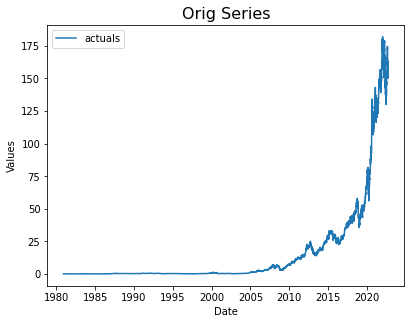

In [98]:
# explore
f = Forecaster(y=price['Close'], current_dates=price['Date'])
f.plot()
plt.title('Orig Series', size=16)
plt.show()

In [99]:
# what if f
f

Forecaster(
    DateStartActuals=1980-12-12T00:00:00.000000000
    DateEndActuals=2022-09-23T00:00:00.000000000
    Freq=None
    N_actuals=10535
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

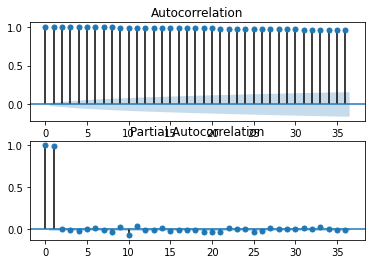

In [100]:
# autocorrelation plot
figs, axs = plt.subplots(2, 1)
f.plot_acf(ax=axs[0],lags=36)
f.plot_pacf(ax=axs[1],lags=36)
plt.show()

In [101]:
# seasonality
# f.seasonal_decompose().plot()
# plt.show()

In [102]:
# ADF test
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: 3.03
the p-value is 1.0000
the series is not stationary
----------------------------------------------------------------------------------------------------


## Prepare Forecast

- set test length: 12 periods
- set forecast horizon: 12 periods
- no other parameters needed for LSTM model

In [103]:
f.set_test_length(50)
f.generate_future_dates(50)

In [104]:
# set estimator
f.set_estimator('lstm')

Epoch 1/2
522/522 [==============================] - 7s 6ms/step - loss: 0.0266 - val_loss: 4.1212e-04
Epoch 2/2
522/522 [==============================] - 2s 5ms/step - loss: 0.0074 - val_loss: 3.9300e-04
Epoch 1/2
525/525 [==============================] - 7s 6ms/step - loss: 0.0292 - val_loss: 5.3409e-04
Epoch 2/2
525/525 [==============================] - 4s 7ms/step - loss: 0.0078 - val_loss: 4.4532e-04


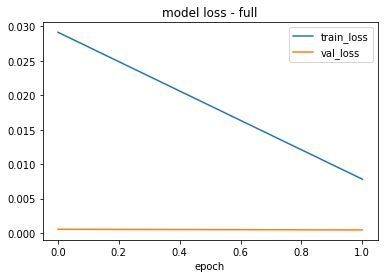

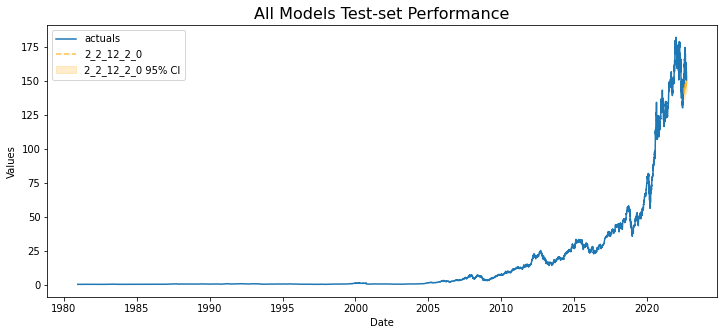

... finished with args:  2_2_12_2_0 ...
CPU times: user 27.3 s, sys: 1.16 s, total: 28.4 s
Wall time: 30.5 s


In [105]:
%%time
# manual tune
for l_ in [2]:
    for ep_ in [2]:
        for ll_ in [12]:
            for r_ in [2]:
                for d_ in [0]:

                    # create argument name for tihs experiment
                    this_nom_ = '_'.join([str(l_), str(ep_), str(ll_), str(r_), str(d_)])

                    # fit the model
                    f.manual_forecast(call_me=this_nom_,
                                    lags=l_,
                                    batch_size=16,
                                    epochs=ep_,
                                    validation_split=.2,
                                    shuffle=True,
                                    activation='tanh',
                                    optimizer='Adam',
                                    learning_rate=0.001,
                                    lstm_layer_sizes=(ll_,)*r_,
                                    dropout=(d_,)*r_,
                                    plot_loss=True)
                    
                    # plot
                    f.plot_test_set(ci=True, figsize=(12, 5))
                    plt.title('All Models Test-set Performance', size=16)
                    plt.show()

                    # chkpoint
                    print('... finished with args: ', this_nom_, '...')

In [106]:
# result
resultDF_ = f.export('model_summaries',determine_best_by='LevelTestSetMAPE')[
    ['ModelNickname','LevelTestSetMAPE','LevelTestSetRMSE','LevelTestSetR2','best_model']
]

# show
resultDF_

,ModelNickname,LevelTestSetMAPE,LevelTestSetRMSE,LevelTestSetR2,best_model
0,2_2_12_2_0,0.089727,16.64023,-3.997071,True


In [107]:
# best name
best_nom_ = resultDF_.iloc[0,0]
best_nom_

'2_2_12_2_0'

In [108]:
# forecast
f.export(['all_fcsts', 'model_summaries', 'best_fcst', 'test_set_predictions', 'lvl_test_set_predictions', 'lvl_fcsts'], determine_best_by='LevelTestSetMAPE').keys()

dict_keys(['model_summaries', 'best_fcst', 'all_fcsts', 'test_set_predictions', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [109]:
# forecast
f.export(['all_fcsts', 'model_summaries', 'best_fcst', 'test_set_predictions', 'lvl_test_set_predictions', 'lvl_fcsts'], determine_best_by='LevelTestSetMAPE')['best_fcst']

,DATE,VALUES,MODEL
0,1980-12-12,0.128348,actual
1,1980-12-15,0.121652,actual
2,1980-12-16,0.112723,actual
3,1980-12-17,0.115513,actual
4,1980-12-18,0.118862,actual
...,...,...,...
10580,2022-11-08,149.149715,2_2_12_2_0
10581,2022-11-09,149.284939,2_2_12_2_0
10582,2022-11-10,149.180766,2_2_12_2_0
10583,2022-11-11,149.533881,2_2_12_2_0


In [134]:
f.export().keys()

dict_keys(['model_summaries', 'best_fcst', 'all_fcsts', 'test_set_predictions', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [141]:
f.export()['best_fcst'].tail(40)

,DATE,VALUES,MODEL
10545,2022-10-04,145.031034,2_2_12_2_0
10546,2022-10-05,143.519846,2_2_12_2_0
10547,2022-10-06,144.586511,2_2_12_2_0
10548,2022-10-07,144.365877,2_2_12_2_0
10549,2022-10-08,143.381216,2_2_12_2_0
10550,2022-10-09,144.585470,2_2_12_2_0
10551,2022-10-10,144.598550,2_2_12_2_0
10552,2022-10-11,144.074680,2_2_12_2_0
10553,2022-10-12,145.854451,2_2_12_2_0
10554,2022-10-13,144.485993,2_2_12_2_0
